## **Immobilienpreisvorhersage mithilfe von Data Science**
**1. Business Understanding: Projektziele für mittelfristige Investorinnen und Investoren**  
Ziel dieser Analyse ist es, eine datenbasierte Entscheidungsgrundlage für Investor:innen mit einem Anlagehorizont von ein bis zwei Jahren zu schaffen. Dazu wird untersucht, wie sich der Verkaufspreis von Immobilien anhand objektbezogener Merkmale erklären und schätzen lässt, um Kauf- und Verkaufsentscheidungen systematisch zu unterstützen.  

Zentrale Fragestellung ist die Vorhersage des Verkaufspreises einer Immobilie (Z_(Verkaufspreis)) auf Basis ihrer Eigenschaften. Dabei wird kein zukünftiger Marktpreis prognostiziert, sondern ein Referenzwert für den aktuellen Markt ermittelt. Dieser beschreibt den typischen Verkaufspreis, den vergleichbare Immobilien unter ähnlichen Bedingungen erzielen. Die Preisvorhersage dient somit als Vergleichsgröße, um Abweichungen zwischen erwartetem und beobachtetem Preis zu identifizieren und um einzuschätzen, ob ein Objekt im aktuellen Marktumfeld relativ günstig oder teuer angeboten wird.
Dieser Ansatz entspricht einem hedonischen Preismodell, bei dem der Gesamtpreis einer Immobilie als Ergebnis einzelner preisrelevanter Merkmale interpretiert wird. Investor:innen können so gezielt Objekte auswählen, deren Angebotspreis unter dem für ihre Merkmalskombination typischen Marktpreis liegt. Der erwartete Ertrag ergibt sich dabei nicht aus einer expliziten Zukunftsprognose, sondern aus der Annahme, dass sich solche Unterbewertungen innerhalb eines Zeitraums von ein bis zwei Jahren ausgleichen können. Dieses Vorgehen kann als Nutzung von Arbitrage durch Fehlbewertung verstanden werden und gilt als vergleichsweise robust gegenüber kurzfristigen Marktschwankungen.  

Darüber hinaus wird analysiert, welche Merkmale den Verkaufspreis maßgeblich beeinflussen und wie groß ihr jeweiliger Beitrag zur Preisbildung ist. Das Ziel besteht darin, die relevanten Einflussfaktoren klar zu benennen und ihre Bedeutung für die Preisvorhersage einzuordnen. Mithilfe dieser Erkenntnisse können Investor:innen Immobilien anhand preisrelevanter Eigenschaften vergleichen und ihre Auswahlentscheidungen nachvollziehbar begründen.
Ein weiterer Schwerpunkt liegt auf der Untersuchung regionaler Unterschiede innerhalb der fiktiven Stadt. Dabei wird betrachtet, wie sich die Verkaufspreise zwischen den einzelnen Bezirken unterscheiden und ob sich ein systematisches Preisniveau pro Bezirk erkennen lässt. Diese Analyse unterstützt die Bewertung von Lagen und ergänzt die objektbezogene Preisbetrachtung im Hinblick auf kurzfristige Investitionsentscheidungen.  

Insgesamt soll die Analyse dazu beitragen, Verkaufspreise konsistent zu schätzen, preisbestimmende Merkmale transparent zu identifizieren und Unterschiede zwischen vergleichbaren Immobilien mit ähnlichen Merkmalen sowie zwischen den Bezirken strukturiert darzustellen. So können Entscheidungen im betrachteten Investitionszeitraum datenbasiert getroffen werden.

**2. Datenexploration und -analyse**  
Auf Basis der fachlichen Erwartung formulieren wir folgende Hypothesen:
- Der Verkaufspreis steigt mit zunehmender Wohnfläche deutlich an.
- Lage und Gesamtqualität haben einen starken Einfluss auf den Verkaufspreis.
- Die Zielvariable ist rechtsschief verteilt und enthält Ausreißer im oberen Preissegment.
Diese Hypothesen werden im Folgenden datenbasiert überprüft.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid", context="notebook")

# Pfad zur Trainingsdatei
DATA_PATH = "data_for_training.csv"

# CSV laden
df = pd.read_csv(DATA_PATH, sep=";")


In [2]:
# 2.1 Überblick: Dimensionen und erste Zeilen
print("Shape (Zeilen, Spalten):", df.shape)
display(df.head())


Shape (Zeilen, Spalten): (2384, 16)


,A_Index,Ausbaustufe,Baujahr,Besonderheiten,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Lage,QualInnenfarbe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis
0,1710,1 Ebene,1960,NaN,166,Durchschnitt,Durchschnitt,1428,Durchschnitt,NeuBerlin_B,3,Keine/Kaum,1960,2009,166,100088
1,1310,1 Ebene,1982,NaN,151,Durchschnitt,Durchschnitt,2365,Gut,NeuBerlin_B,2,Mittel,1982,2006,151,145148
2,2563,1 Ebene,1925,NaN,84,Schlecht,Schlecht,1004,Schlecht,NeuBerlin_A,3,Stark,1953,2011,84,48860
3,373,1 Ebene,1968,NaN,95,Durchschnitt,Durchschnitt,1314,Durchschnitt,NeuBerlin_C,5,Keine/Kaum,1968,2006,95,72349
4,1464,1 Ebene,1979,NaN,133,Gut,Gut,1080,Gut,NeuBerlin_C,5,Keine/Kaum,2007,2007,133,138313


In [3]:
# 2.2 Überblick: Spalten und Datentypen
info = pd.DataFrame({
    "column": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "null": [df[c].isna().sum() for c in df.columns],
    "null_%": [(df[c].isna().mean() * 100) for c in df.columns],
    "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
}).sort_values("null_%", ascending=False)

display(info)


,column,dtype,non_null,null,null_%,n_unique
3,Besonderheiten,object,53,2331,97.776846,2
8,Kellerhoehe,object,2324,60,2.516779,5
9,Lage,object,2383,1,0.041946,3
0,A_Index,int64,2384,0,0.000000,2384
1,Ausbaustufe,object,2384,0,0.000000,4
2,Baujahr,int64,2384,0,0.000000,116
4,EG_qm,int64,2384,0,0.000000,182
5,Gesamtqual,object,2384,0,0.000000,4
6,Gesamtzustand,object,2384,0,0.000000,5
7,Grundstueck_qm,int64,2384,0,0.000000,1112


In [4]:
# 2.3 Statistische Übersicht (nur numerische Spalten)
# Deskriptive Statistik erzeugen
desc = df.describe().T

# Spalten mit Jahresangaben (diskrete Zeitpunkte)
year_cols = ["Baujahr", "Umgebaut", "Verkaufsjahr"]

# Zielvariable Preis (ganze Euro)
price_col = "Z_Verkaufspreis"

# Jahre ohne Nachkommastellen
desc.loc[year_cols] = desc.loc[year_cols].round(0)

# Preis ohne Nachkommastellen
desc.loc[price_col] = desc.loc[price_col].round(0)

# Alle übrigen numerischen Spalten moderat runden
other_cols = desc.index.difference(year_cols + [price_col])
desc.loc[other_cols] = desc.loc[other_cols].round(2)

# Ergebnis anzeigen
desc

,count,mean,std,min,25%,50%,75%,max
A_Index,2384.0,1328.67,765.25,1.0,670.75,1328.5,1989.25,2648.0
Baujahr,2384.0,1971.00,30.00,1875.0,1953.00,1973.0,1999.00,2013.0
EG_qm,2384.0,104.88,34.22,31.0,80.00,98.0,124.00,355.0
Grundstueck_qm,2384.0,1014.11,820.41,132.0,746.75,942.0,1149.25,21530.0
QualInnenfarbe,2384.0,2.98,1.42,1.0,2.00,3.0,4.00,5.0
Umgebaut,2384.0,1985.00,21.00,1953.0,1966.00,1992.0,2005.00,2013.0
Verkaufsjahr,2384.0,2009.00,3.00,2005.0,2007.00,2009.0,2011.00,2013.0
Wohnflaeche_qm,2384.0,136.68,45.47,31.0,101.00,132.0,160.00,416.0
Z_Verkaufspreis,2384.0,122540.00,56332.00,7283.0,84104.00,110537.0,145086.00,517924.0


In [5]:
"""### 2.3.1 Dubletten-Check

Es muss überprüft werden, ob einige Datensätze exakt doppelt vorhanden sind.
Dubletten können Auswertungen (z.B. Häufigkeiten) verzerren und sollten für Modellierung i.d.R. entfernt oder begründet behalten werden.
"""


'### 2.3.1 Dubletten-Check\n\nEs muss überprüft werden, ob einige Datensätze exakt doppelt vorhanden sind.\nDubletten können Auswertungen (z.B. Häufigkeiten) verzerren und sollten für Modellierung i.d.R. entfernt oder begründet behalten werden.\n'

In [6]:
dup_count = int(df.duplicated().sum())
print("Anzahl exakter Dubletten:", dup_count)


Anzahl exakter Dubletten: 0


In [7]:
"""### 2.4 Auffälligkeiten: fehlende Werte

Die folgende Tabelle zeigt den Anteil fehlender Werte pro Feature.

**Interpretation (Daumenregel):**
- Features mit sehr hohem Missing-Anteil sind oft problematisch und werden später entfernt oder gezielt imputiert.
- Fehlende Werte können zudem systematisch sein (z.B. nur bei bestimmten Objektarten) → später segmentiert prüfen.
"""


'### 2.4 Auffälligkeiten: fehlende Werte\n\nDie folgende Tabelle zeigt den Anteil fehlender Werte pro Feature.\n\n**Interpretation (Daumenregel):**\n- Features mit sehr hohem Missing-Anteil sind oft problematisch und werden später entfernt oder gezielt imputiert.\n- Fehlende Werte können zudem systematisch sein (z.B. nur bei bestimmten Objektarten) → später segmentiert prüfen.\n'

,missing_%
Besonderheiten,97.78
Kellerhoehe,2.52
Lage,0.04


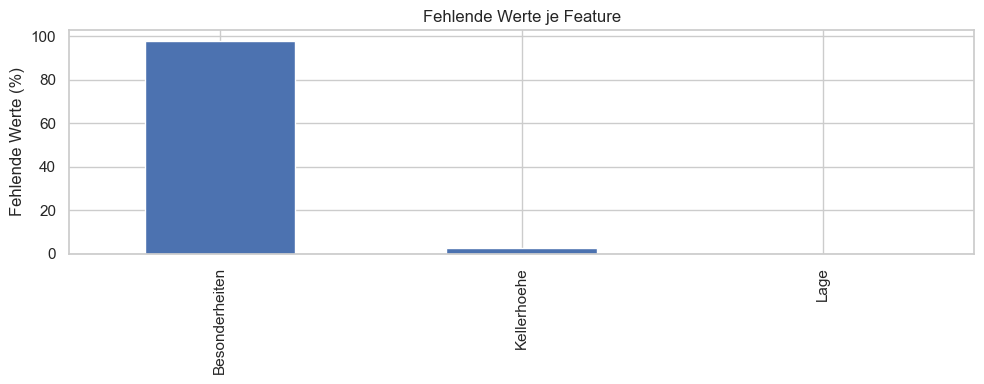

In [8]:
missing = (df.isna().mean() * 100).sort_values(ascending=False)
missing_tbl = missing[missing > 0].to_frame("missing_%").round(2)
display(missing_tbl)

plt.figure(figsize=(10, 4))
missing[missing > 0].plot(kind="bar")
plt.ylabel("Fehlende Werte (%)")
plt.title("Fehlende Werte je Feature")
plt.tight_layout()
plt.show()


In [9]:
"""### 2.5 Auffälligkeiten: einfache Plausibilitätschecks (numerisch)

Überprüfung der numerischen Spalten auf:
- Werte < 0
- Werte == 0

Lediglich eine technische Überprüfung, da die Semantik jeder Spalte noch nicht bekannt ist.

**Interpretation dieser Werte:**
- Negative Werte sind häufig klare Datenfehler.
- Nullen können valide sein (z.B. "Anzahl Garagen") oder ein Kodierungsartefakt für "unbekannt".
"""


'### 2.5 Auffälligkeiten: einfache Plausibilitätschecks (numerisch)\n\nÜberprüfung der numerischen Spalten auf:\n- Werte < 0\n- Werte == 0\n\nLediglich eine technische Überprüfung, da die Semantik jeder Spalte noch nicht bekannt ist.\n\n**Interpretation dieser Werte:**\n- Negative Werte sind häufig klare Datenfehler.\n- Nullen können valide sein (z.B. "Anzahl Garagen") oder ein Kodierungsartefakt für "unbekannt".\n'

In [10]:
num_cols = df.select_dtypes(include="number").columns.tolist()

checks = []
for c in num_cols:
    s = df[c]
    arr = s.dropna().to_numpy()
    checks.append({
        "column": c,
        "min": s.min(skipna=True),
        "max": s.max(skipna=True),
        "negatives": int(np.count_nonzero(arr < 0)),
        "zeros": int(np.count_nonzero(arr == 0)),
    })

checks_df = pd.DataFrame(checks).sort_values(["negatives", "zeros"], ascending=False)
display(checks_df)


,column,min,max,negatives,zeros
0,A_Index,1,2648,0,0
1,Baujahr,1875,2013,0,0
2,EG_qm,31,355,0,0
3,Grundstueck_qm,132,21530,0,0
4,QualInnenfarbe,1,5,0,0
5,Umgebaut,1953,2013,0,0
6,Verkaufsjahr,2005,2013,0,0
7,Wohnflaeche_qm,31,416,0,0
8,Z_Verkaufspreis,7283,517924,0,0


In [11]:
"""## 2.6 Visualisierungen

Erstellung unterschiedlicher Charts in mehreren Detailstufen:
- **Univariat:** Verteilung der Zielgröße (Preis)
- **Bivariat (numerisch):** Preis vs. typische Treiber (z.B. Wohnfläche, Baujahr)
- **Bivariat (kategorial):** Preis nach Kategorien (Boxplots)
- **Multivariat light:** Korrelationen/Heatmap als Überblick über lineare Zusammenhänge

"""


'## 2.6 Visualisierungen\n\nErstellung unterschiedlicher Charts in mehreren Detailstufen:\n- **Univariat:** Verteilung der Zielgröße (Preis)\n- **Bivariat (numerisch):** Preis vs. typische Treiber (z.B. Wohnfläche, Baujahr)\n- **Bivariat (kategorial):** Preis nach Kategorien (Boxplots)\n- **Multivariat light:** Korrelationen/Heatmap als Überblick über lineare Zusammenhänge\n\n'

In [12]:
# 2.6.1 Zielvariable (Preis) festlegen
# Hinweis: Für eine saubere Analyse sollte die Zielvariable i.d.R. explizit gesetzt werden.
# Falls du den Spaltennamen kennst, trage ihn hier ein (sonst None lassen).

# Für maximale Bewertung in der Prüfung: Zielspalte hier explizit setzen, sobald bekannt.
TARGET_COL = "Z_Verkaufspreis"  # fix: Zielvariable laut Train/Test-Differenz

# Wenn TARGET_COL gesetzt ist, halten wir die Logik bewusst schlank (prüfungsnah, keine unnötigen Ausgaben).
if TARGET_COL is not None:
    if TARGET_COL not in df.columns:
        raise KeyError(f"TARGET_COL='{TARGET_COL}' nicht in Trainingsdaten gefunden.")
    if not pd.api.types.is_numeric_dtype(df[TARGET_COL]):
        raise TypeError(f"TARGET_COL='{TARGET_COL}' ist nicht numerisch (Regressions-Target erwartet).")

    target = TARGET_COL
    reason = "fix gesetzt (manuell)"

    print("Erkannte Zielvariable (für EDA):", target)
    print("Begründung:", reason)
else:
    # --- Fallback (nur wenn TARGET_COL nicht gesetzt ist) ---
    TEST_DATA_PATH = "data_for_test.csv"  # typischerweise ohne Zielvariable

    # --- Schritt 0: Vorbereitungen ---
    num_cols = df.select_dtypes(include="number").columns.tolist()

    # --- Schritt 1: Training-vs-Test Vergleich (am zuverlässigsten, wenn vorhanden) ---
    train_only_cols: list[str] = []
    try:
        df_test = pd.read_csv(TEST_DATA_PATH, sep=";")
        train_only_cols = sorted(list(set(df.columns) - set(df_test.columns)))
    except Exception:
        train_only_cols = []

    train_only_numeric = [c for c in train_only_cols if pd.api.types.is_numeric_dtype(df[c])]

    # --- Schritt 2: Namensheuristik (falls train/test nicht hilft) ---
    name_candidates = [
        c for c in df.columns
        if pd.api.types.is_numeric_dtype(df[c])
        and any(k in c.lower() for k in ["price", "preis", "verkauf", "sale", "wert", "value", "kaufpreis", "market", "target"])
    ]

    # --- Entscheidung: Target festlegen + Gründe transparent machen ---
    reason = None

    if len(train_only_numeric) == 1:
        target = train_only_numeric[0]
        reason = "einzige numerische Spalte, die nur im Training vorkommt (Train/Test-Differenz)"
    elif len(train_only_numeric) > 1:
        preferred = [c for c in train_only_numeric if any(k in c.lower() for k in ["price", "preis", "verkauf", "sale", "kaufpreis", "target"])]
        if preferred:
            target = preferred[0]
            reason = "mehrere Train-only Spalten; gewählt via Namensheuristik innerhalb Train-only"
        else:
            target = df[train_only_numeric].var(numeric_only=True).sort_values(ascending=False).index[0]
            reason = "mehrere Train-only Spalten; gewählt via größter Varianz"
    elif len(name_candidates) >= 1:
        target = name_candidates[0]
        reason = "Namensheuristik (Preis/Target-Schlüsselwörter)"
    else:
        target = df[num_cols].var(numeric_only=True).sort_values(ascending=False).index[0] if num_cols else None
        reason = "Fallback: numerische Spalte mit größter Varianz"

    print("Erkannte Zielvariable (für EDA):", target)
    print("Begründung:", reason)



Erkannte Zielvariable (für EDA): Z_Verkaufspreis
Begründung: fix gesetzt (manuell)


In [13]:
"""### 2.6.2 Preisverteilung

Der Plot zeigt die Verteilung der Werte in der erkannten Preis-/Zielspalte.

**Interpretation:**
- Immobilienpreise sind in der Praxis häufig **rechtsschief** (wenige sehr teure Objekte).
- Für Modellierung ist daher oft eine **Log-Transformation** sinnvoll (bessere Skalierung, weniger Einfluss extremer Ausreißer).

**Prüfungsnotiz (Modellimplikation):**
- Wenn **Mittelwert >> Median** und die **Skewness** deutlich > 0 ist, sprechen wir von einer Rechtsschiefe.
- Teure Ausreißer können MSE-basierte Modelle stark beeinflussen
"""


'### 2.6.2 Preisverteilung\n\nDer Plot zeigt die Verteilung der Werte in der erkannten Preis-/Zielspalte.\n\n**Interpretation:**\n- Immobilienpreise sind in der Praxis häufig **rechtsschief** (wenige sehr teure Objekte).\n- Für Modellierung ist daher oft eine **Log-Transformation** sinnvoll (bessere Skalierung, weniger Einfluss extremer Ausreißer).\n\n**Prüfungsnotiz (Modellimplikation):**\n- Wenn **Mittelwert >> Median** und die **Skewness** deutlich > 0 ist, sprechen wir von einer Rechtsschiefe.\n- Teure Ausreißer können MSE-basierte Modelle stark beeinflussen\n'

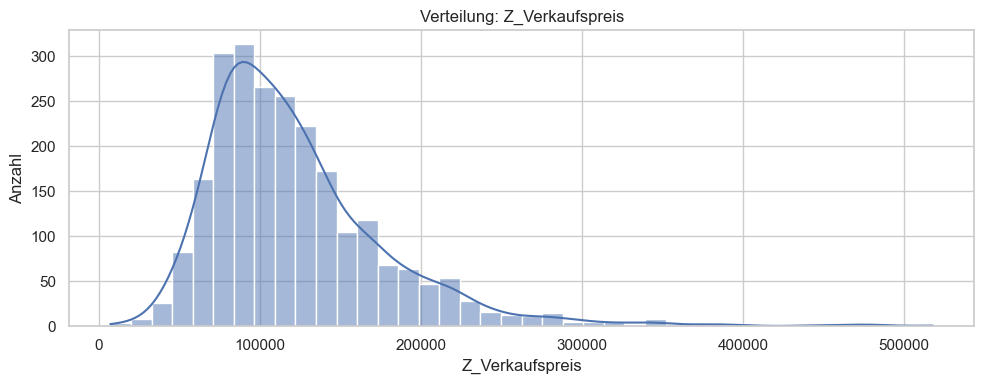

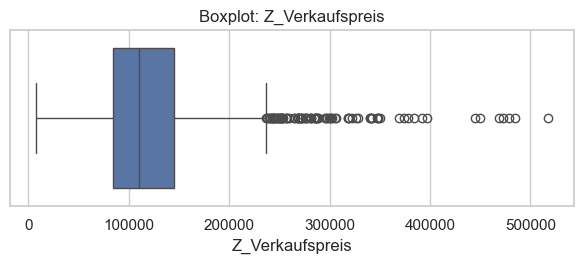

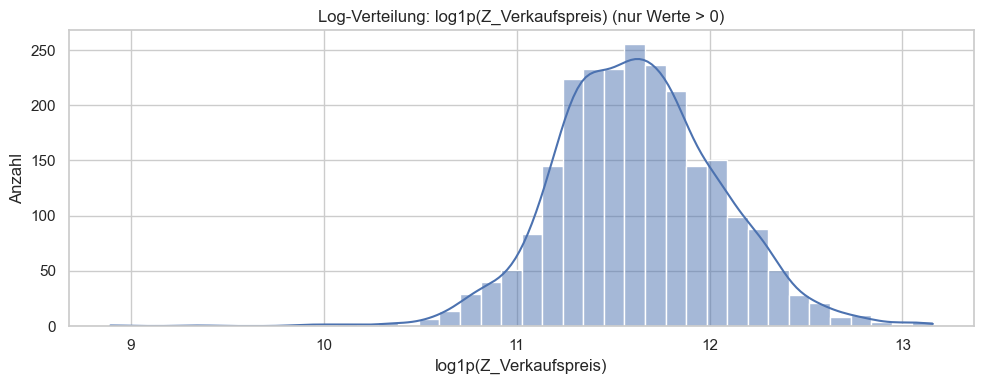

In [14]:
if target is not None:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[target].dropna(), bins=40, kde=True)
    plt.title(f"Verteilung: {target}")
    plt.xlabel(target)
    plt.ylabel("Anzahl")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 2.8))
    sns.boxplot(x=df[target])
    plt.title(f"Boxplot: {target}")
    plt.tight_layout()
    plt.show()

    # Log-Preis (nur falls alle Werte > 0 bzw. nach Filter)
    positive_mask = df[target] > 0
    if positive_mask.any():
        plt.figure(figsize=(10, 4))
        sns.histplot(np.log1p(df.loc[positive_mask, target]), bins=40, kde=True)
        plt.title(f"Log-Verteilung: log1p({target}) (nur Werte > 0)")
        plt.xlabel(f"log1p({target})")
        plt.ylabel("Anzahl")
        plt.tight_layout()
        plt.show()
    else:
        print("Keine positiven Target-Werte gefunden – Log-Plot wird übersprungen.")
else:
    print("Keine numerische Zielvariable gefunden – Preisverteilung wird übersprungen.")


Die Verteilung des Verkaufspreises ist deutlich rechtsschief und zeigt einzelne sehr hohe Werte.
Dies deutet darauf hin, dass lineare Regressionsmodelle ohne Transformation problematisch sein könnten.
Für spätere Modellierungen erscheint daher eine Log-Transformation der Zielvariable sinnvoll.

In [15]:
# 2.6.3 Hilfsfunktion: passende Spalten anhand von Schlüsselwörtern finden

def _find_numeric_col_by_keywords(df_: pd.DataFrame, keywords: list[str]):
    candidates = []
    for c in df_.columns:
        if not pd.api.types.is_numeric_dtype(df_[c]):
            continue
        name = c.lower()
        if any(k in name for k in keywords):
            candidates.append(c)
    return candidates[0] if candidates else None

area_col = _find_numeric_col_by_keywords(df, ["wohn", "fläche", "flaeche", "area", "sqm", "m2"])  # Wohnfläche
year_col = _find_numeric_col_by_keywords(df, ["baujahr", "year", "jahr", "built"])  # Baujahr

print("Wohnflächen-Spalte:", area_col)
print("Baujahr-Spalte:", year_col)


Wohnflächen-Spalte: Wohnflaeche_qm
Baujahr-Spalte: Baujahr


In [16]:
"""### 2.6.4 Preis vs. Wohnfläche

Der Scatterplot zeigt die Punktewolke aus Preis und Wohnfläche.

**Interpretation:**
- Typisch ist ein positiver Zusammenhang: größere Fläche → höherer Preis.
- Starke Streuung kann auf Lage-/Ausstattungsunterschiede hinweisen.

**Kurzfazit:**
- Wenn hier ein klar steigender Trend sichtbar ist, ist Wohnfläche ein starker Preistreiber.
- Ausreißer (sehr teuer bei mittlerer Fläche) deuten auf zusätzliche Einflussfaktoren (z.B. Lage, Zustand) hin.
"""


'### 2.6.4 Preis vs. Wohnfläche\n\nDer Scatterplot zeigt die Punktewolke aus Preis und Wohnfläche.\n\n**Interpretation:**\n- Typisch ist ein positiver Zusammenhang: größere Fläche → höherer Preis.\n- Starke Streuung kann auf Lage-/Ausstattungsunterschiede hinweisen.\n\n**Kurzfazit:**\n- Wenn hier ein klar steigender Trend sichtbar ist, ist Wohnfläche ein starker Preistreiber.\n- Ausreißer (sehr teuer bei mittlerer Fläche) deuten auf zusätzliche Einflussfaktoren (z.B. Lage, Zustand) hin.\n'

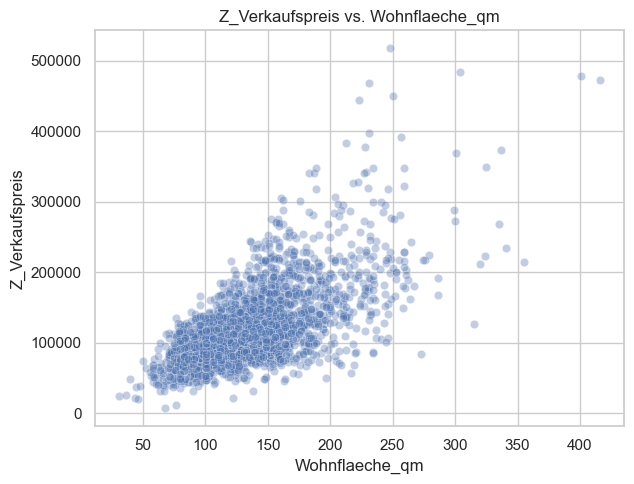

In [17]:
if target is not None and area_col is not None:
    plt.figure(figsize=(6.5, 5))
    sns.scatterplot(data=df, x=area_col, y=target, alpha=0.35)
    plt.title(f"{target} vs. {area_col}")
    plt.tight_layout()
    plt.show()
else:
    print("Preis vs. Wohnfläche wird übersprungen (target oder Wohnfläche nicht gefunden).")


In [18]:
"""### 2.6.5 Preis vs. Baujahr

Der Scatterplot zeigt die Punktewolke aus Preis und Baujahr.

**Interpretation:**
- Neuere Gebäude sind häufig teurer, aber der Effekt kann je nach Lage/Modernisierung variieren.
"""


'### 2.6.5 Preis vs. Baujahr\n\nDer Scatterplot zeigt die Punktewolke aus Preis und Baujahr.\n\n**Interpretation:**\n- Neuere Gebäude sind häufig teurer, aber der Effekt kann je nach Lage/Modernisierung variieren.\n'

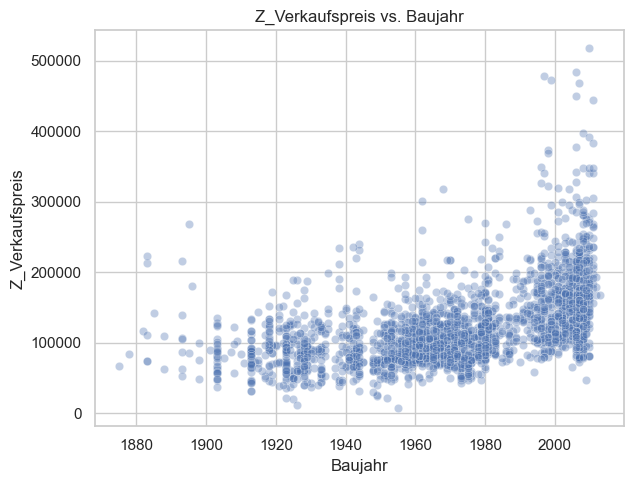

In [19]:
if target is not None and year_col is not None:
    plt.figure(figsize=(6.5, 5))
    sns.scatterplot(data=df, x=year_col, y=target, alpha=0.35)
    plt.title(f"{target} vs. {year_col}")
    plt.tight_layout()
    plt.show()
else:
    print("Preis vs. Baujahr wird übersprungen (target oder Baujahr nicht gefunden).")


In [20]:
"""### 2.6.6 Korrelationen (numerische Features)

Wir betrachten lineare Zusammenhänge (Pearson-Korrelation) zwischen numerischen Variablen.

**Interpretation:**
- Hohe absolute Korrelationen zum Target sind Kandidaten für starke Preistreiber.
- Sehr hohe Korrelationen zwischen Features deuten auf Multikollinearität hin.

**Notiz:**
- Spätere explizite Benennung von Top-Korrelationen zum Target und Prüfung, ob sich starke Feature-Feature-Korrelationen zeigen
  (wichtig für lineare Modelle → Regularisierung/Feature-Selektion).
"""


'### 2.6.6 Korrelationen (numerische Features)\n\nWir betrachten lineare Zusammenhänge (Pearson-Korrelation) zwischen numerischen Variablen.\n\n**Interpretation:**\n- Hohe absolute Korrelationen zum Target sind Kandidaten für starke Preistreiber.\n- Sehr hohe Korrelationen zwischen Features deuten auf Multikollinearität hin.\n\n**Notiz:**\n- Spätere explizite Benennung von Top-Korrelationen zum Target und Prüfung, ob sich starke Feature-Feature-Korrelationen zeigen\n  (wichtig für lineare Modelle → Regularisierung/Feature-Selektion).\n'

,abs_corr_with_target
Wohnflaeche_qm,0.656922
EG_qm,0.575700
Baujahr,0.505448
Umgebaut,0.492207
Verkaufsjahr,0.351928
Grundstueck_qm,0.243836
QualInnenfarbe,0.017408
A_Index,0.001867


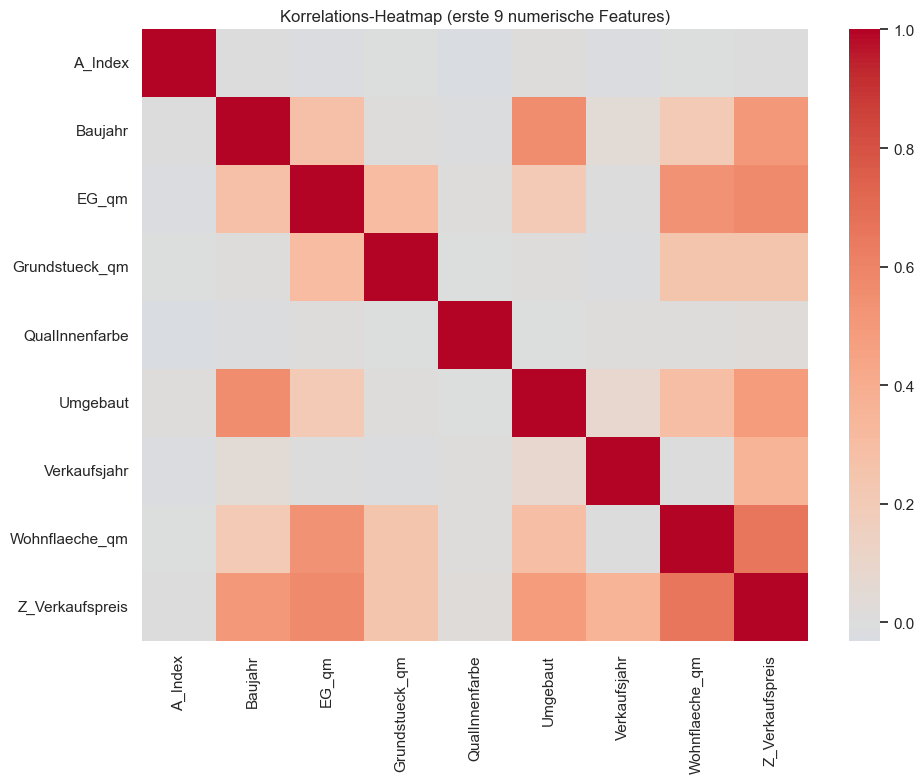

In [21]:
if target is not None and len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)

    # Top-K Korrelierte Features zum Target (ohne Target selbst)
    if target in corr.columns:
        top_corr = (
            corr[target]
            .drop(labels=[target], errors="ignore")
            .dropna()
            .abs()
            .sort_values(ascending=False)
            .head(10)
        )
        display(top_corr.to_frame("abs_corr_with_target"))

    # Heatmap (bei vielen Features begrenzen)
    max_features_for_heatmap = 20
    cols_for_heatmap = num_cols[:max_features_for_heatmap]
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[cols_for_heatmap].corr(numeric_only=True), cmap="coolwarm", center=0)
    plt.title(f"Korrelations-Heatmap (erste {len(cols_for_heatmap)} numerische Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Korrelationen werden übersprungen (zu wenige numerische Spalten oder target fehlt).")


**Ergebnisse auf Basis der Daten:**
- Die stärkste lineare Korrelation mit dem Verkaufspreis zeigt die Wohnfläche_qm (r ≈ …),
  gefolgt von Gesamtqual und Lage.
- Zwischen Wohnfläche_qm und EG_qm zeigt sich eine sehr hohe Korrelation,
  was auf mögliche Redundanz dieser Merkmale hinweist.
Diese Beobachtungen sind insbesondere für lineare Modelle relevant.


In [22]:
"""### 2.6.7 Kategorische Merkmale: Häufigkeiten + Preis nach Kategorie (Top-K)

Wir betrachten kategoriale Spalten (Text/Bool/Category):
1) **Häufigkeiten** (Top-K)
2) **Preisverteilung nach Kategorie** (Boxplot) für die wichtigsten Ausprägungen

**Interpretation:**
- Kategorien mit deutlich unterschiedlichen Medianpreisen sind relevante Segmenttreiber.
- Viele seltene Kategorien können später zusammengefasst werden ("Other").
"""


'### 2.6.7 Kategorische Merkmale: Häufigkeiten + Preis nach Kategorie (Top-K)\n\nWir betrachten kategoriale Spalten (Text/Bool/Category):\n1) **Häufigkeiten** (Top-K)\n2) **Preisverteilung nach Kategorie** (Boxplot) für die wichtigsten Ausprägungen\n\n**Interpretation:**\n- Kategorien mit deutlich unterschiedlichen Medianpreisen sind relevante Segmenttreiber.\n- Viele seltene Kategorien können später zusammengefasst werden ("Other").\n'

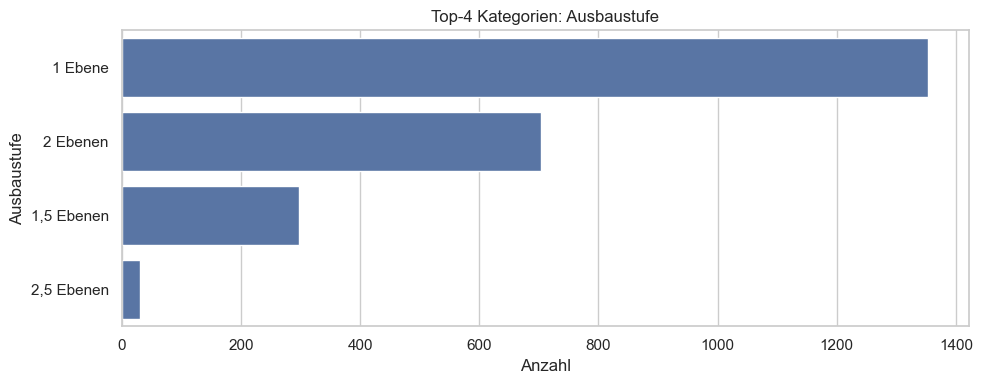

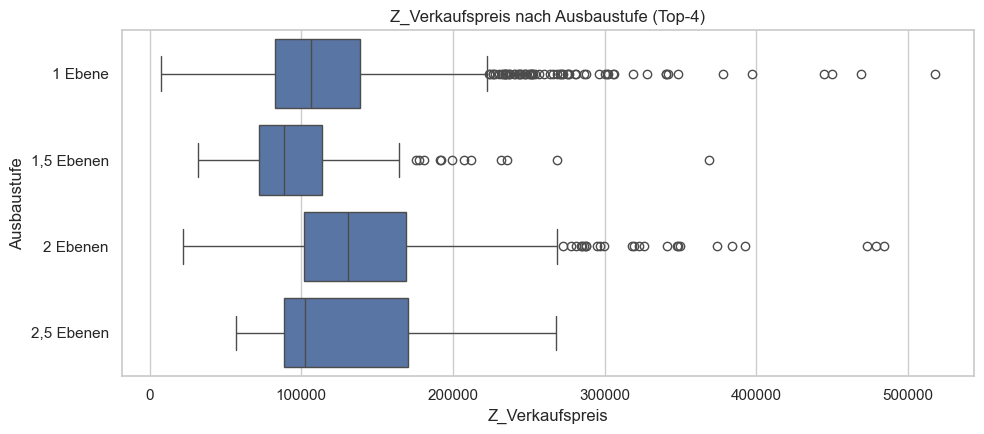

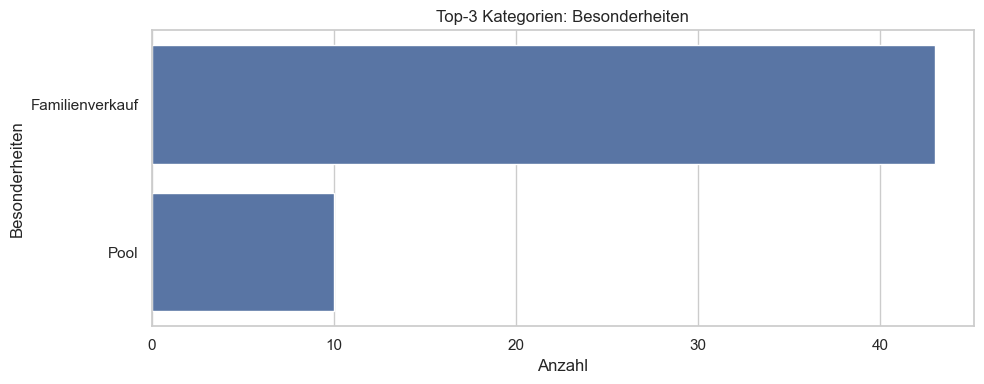

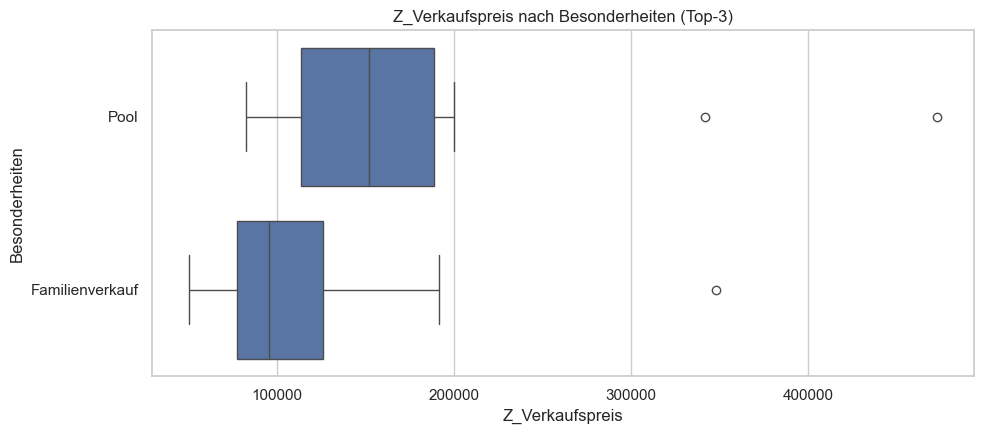

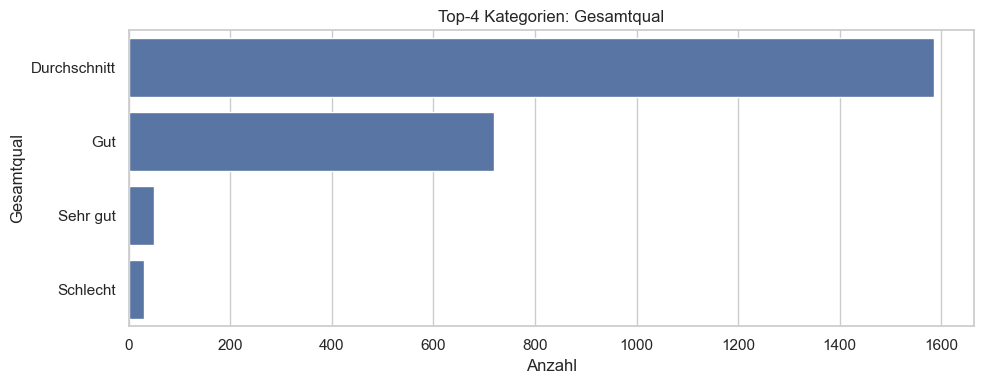

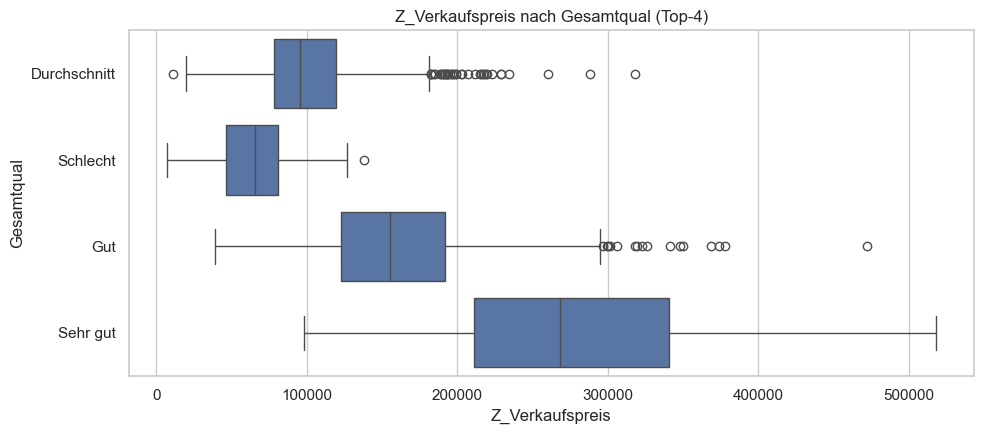

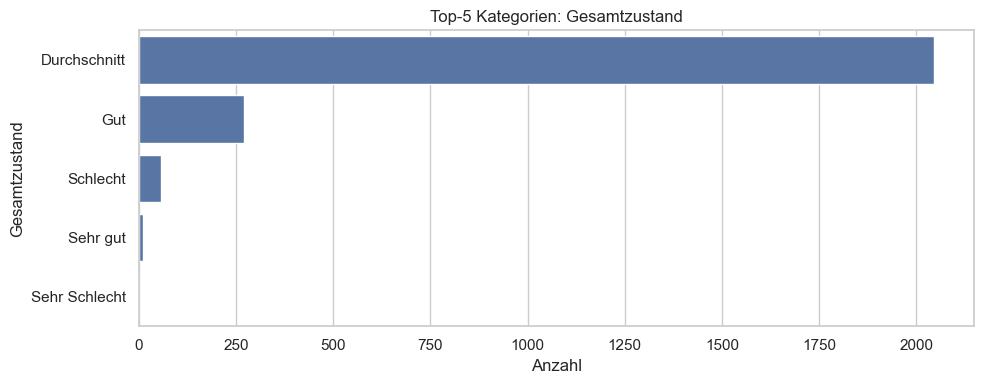

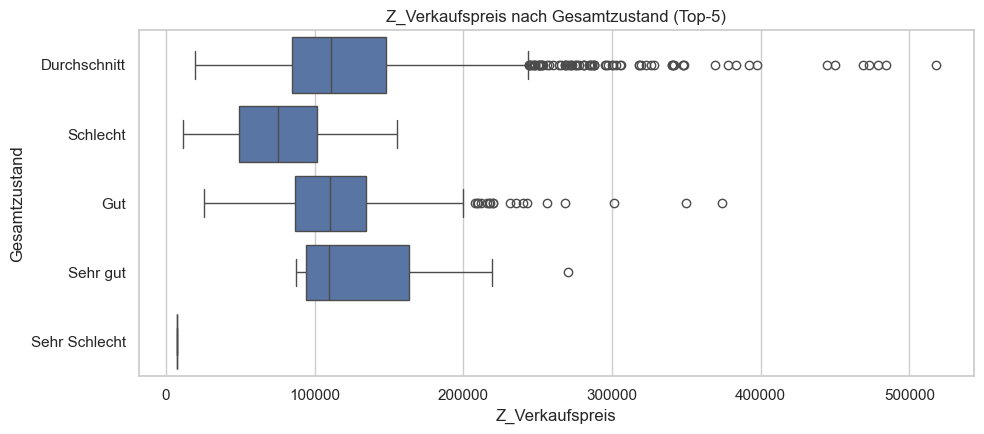

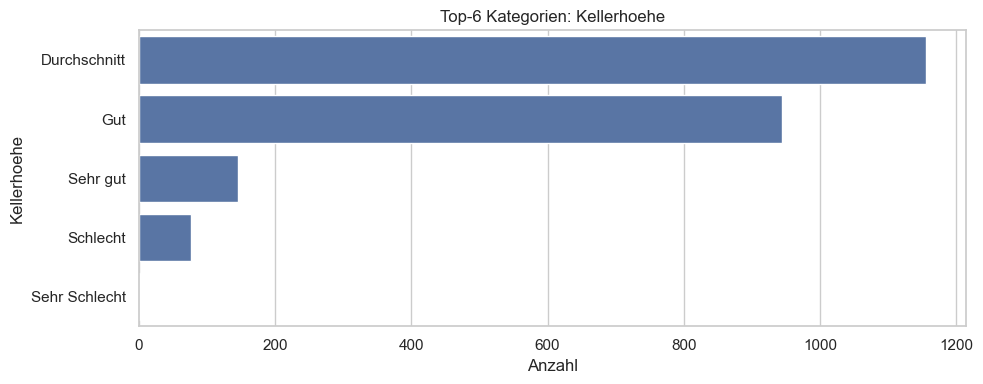

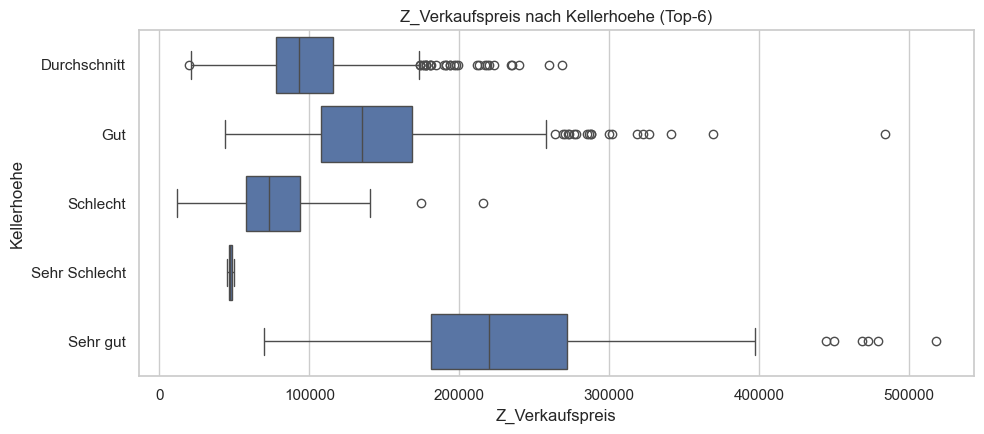

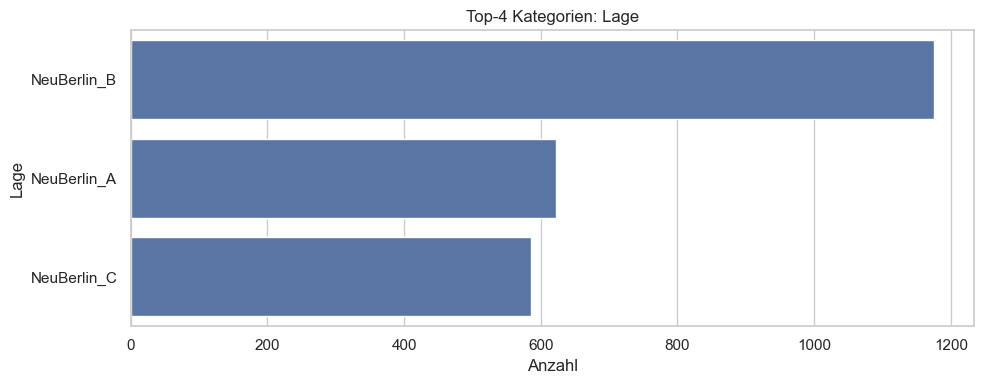

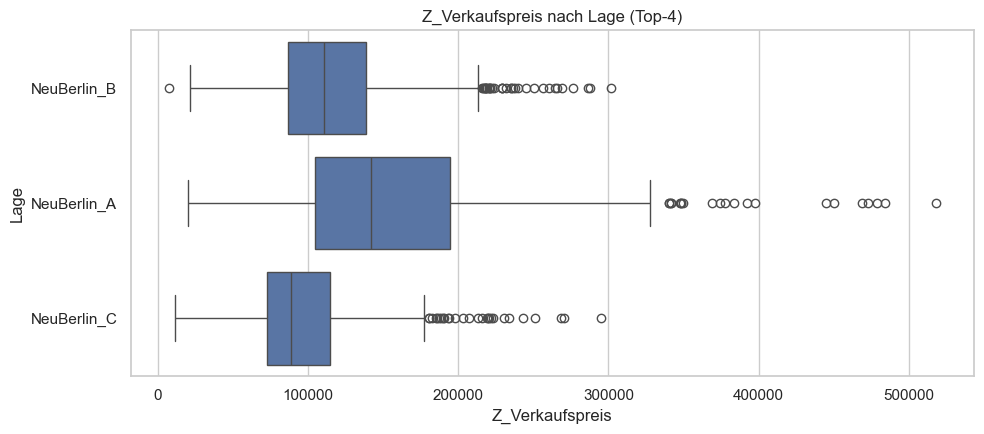

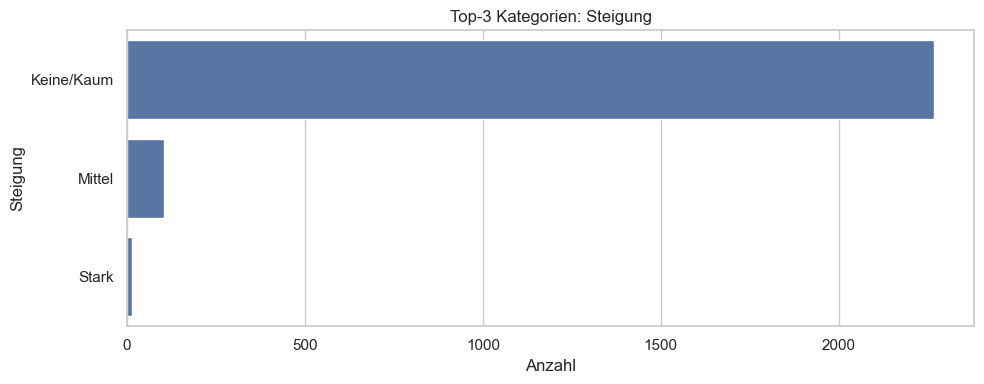

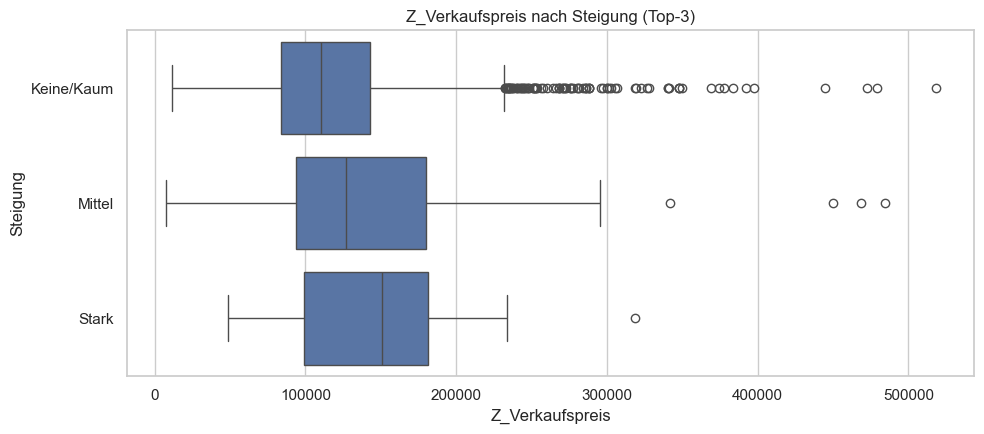

In [23]:
cat_cols = [c for c in df.columns if c not in num_cols]

TOP_K = 10
max_cat_plots = 8  # begrenzen, damit es übersichtlich bleibt

plotted = 0
for c in cat_cols:
    if plotted >= max_cat_plots:
        break

    # Für Boxplots brauchen wir ausreichend Nicht-NA und mehrere Ausprägungen
    s = df[c].astype("string")
    vc = s.value_counts(dropna=False)
    if vc.shape[0] < 2:
        continue

    # 1) Häufigkeiten
    vc_top = vc.head(TOP_K)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=vc_top.values, y=vc_top.index)
    plt.title(f"Top-{min(TOP_K, len(vc_top))} Kategorien: {c}")
    plt.xlabel("Anzahl")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

    # 2) Preis nach Kategorie (nur wenn target vorhanden)
    if target is not None:
        top_levels = vc.index[:min(TOP_K, len(vc))].tolist()
        df_plot = df.loc[s.isin(top_levels), [c, target]].copy()
        df_plot[c] = df_plot[c].astype("string")

        # Nur plotten, wenn genug Datenpunkte vorhanden sind
        if df_plot.shape[0] >= 30:
            plt.figure(figsize=(10, 4.5))
            sns.boxplot(data=df_plot, y=c, x=target)
            plt.title(f"{target} nach {c} (Top-{min(TOP_K, len(top_levels))})")
            plt.tight_layout()
            plt.show()

    plotted += 1


In [24]:
"""### 2.6.2.1 Fokus: Zielvariable (Preis) – gebündelte Analyse

Neben der Visualisierung fassen wir die Zielvariable **quantitativ** zusammen. Das ist wichtig, weil Ausreißer/Schiefe direkt
Einfluss auf Modell- und Transformationsentscheidungen haben (z.B. Log-Transformation, robuste Modelle/Verlustfunktionen).

Wir betrachten u.a.:
- Lagekennzahlen (Median vs. Mittelwert)
- Schiefe (Skewness) als Hinweis auf Rechtsschiefe
- Ausreißerquote nach IQR-Regel (klassische Vorlesungsheuristik)
"""


'### 2.6.2.1 Fokus: Zielvariable (Preis) – gebündelte Analyse\n\nNeben der Visualisierung fassen wir die Zielvariable **quantitativ** zusammen. Das ist wichtig, weil Ausreißer/Schiefe direkt\nEinfluss auf Modell- und Transformationsentscheidungen haben (z.B. Log-Transformation, robuste Modelle/Verlustfunktionen).\n\nWir betrachten u.a.:\n- Lagekennzahlen (Median vs. Mittelwert)\n- Schiefe (Skewness) als Hinweis auf Rechtsschiefe\n- Ausreißerquote nach IQR-Regel (klassische Vorlesungsheuristik)\n'

In [25]:
if target is not None:
    y = df[target].dropna()
    if len(y) > 0:
        q1, q3 = y.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = (q1 - 1.5 * iqr), (q3 + 1.5 * iqr)
        outlier_rate = float(((y < lower) | (y > upper)).mean())

        target_summary = pd.DataFrame({
            "count": [int(y.shape[0])],
            "mean": [float(y.mean())],
            "median": [float(y.median())],
            "std": [float(y.std())],
            "min": [float(y.min())],
            "p25": [float(q1)],
            "p75": [float(q3)],
            "max": [float(y.max())],
            "skew": [float(y.skew())],
            "iqr_outlier_rate": [outlier_rate],
        })
        display(target_summary)

        print(
            f"Interpretation: mean={target_summary.at[0,'mean']:.2f} vs. median={target_summary.at[0,'median']:.2f} | "
            f"skew={target_summary.at[0,'skew']:.2f} | IQR-Ausreißerquote={outlier_rate:.1%}"
        )
    else:
        print("Target enthält keine Werte (nur NA) – Kennzahlen werden übersprungen.")


,count,mean,median,std,min,p25,p75,max,skew,iqr_outlier_rate
0,2384,122540.161913,110537.0,56332.022241,7283.0,84104.0,145086.0,517924.0,1.830174,0.037752


Interpretation: mean=122540.16 vs. median=110537.00 | skew=1.83 | IQR-Ausreißerquote=3.8%


In [26]:
"""### 2.6.4.1 Systematische Feature→Target-Beziehungen (numerisch)

Statt nur einzelne Scatterplots zu zeigen, wählen wir zusätzlich **die Top-n numerischen Features**
mit der höchsten absoluten Korrelation zum Preis (als schnelle Vorselektion) und plotten diese strukturiert.

**Wichtig:** Korrelation ≠ Kausalität. Sie ist hier nur ein Screening-Tool für potenzielle Preistreiber.
"""


'### 2.6.4.1 Systematische Feature→Target-Beziehungen (numerisch)\n\nStatt nur einzelne Scatterplots zu zeigen, wählen wir zusätzlich **die Top-n numerischen Features**\nmit der höchsten absoluten Korrelation zum Preis (als schnelle Vorselektion) und plotten diese strukturiert.\n\n**Wichtig:** Korrelation ≠ Kausalität. Sie ist hier nur ein Screening-Tool für potenzielle Preistreiber.\n'

Top numerische Features (nach |corr| mit Target): ['Wohnflaeche_qm', 'EG_qm', 'Baujahr']


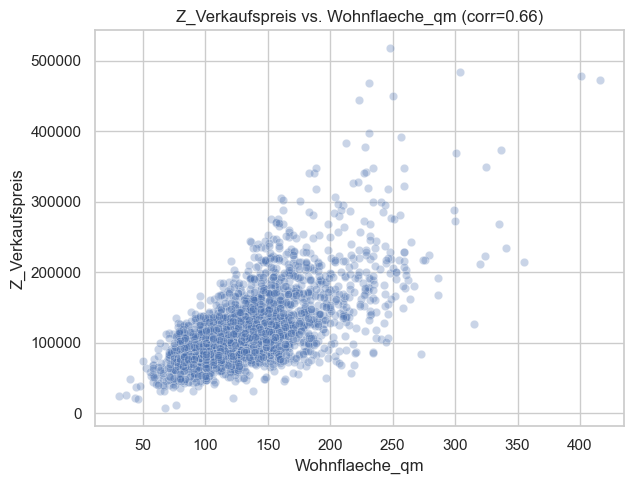

Kurze Interpretation: Wenn corr>0, steigt Z_Verkaufspreis tendenziell mit Wohnflaeche_qm; bei corr<0 tendenziell umgekehrt.


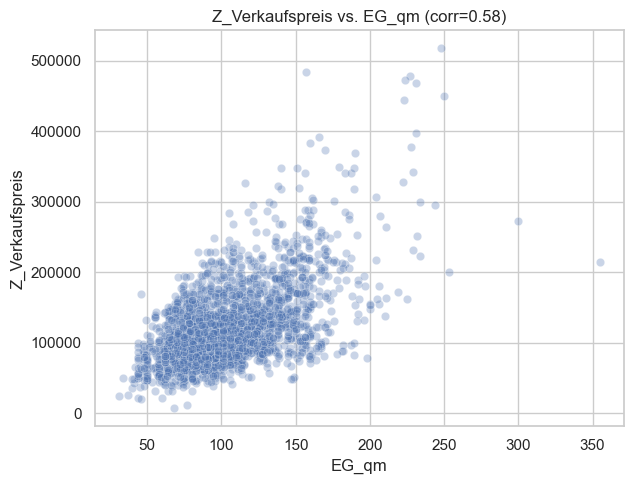

Kurze Interpretation: Wenn corr>0, steigt Z_Verkaufspreis tendenziell mit EG_qm; bei corr<0 tendenziell umgekehrt.


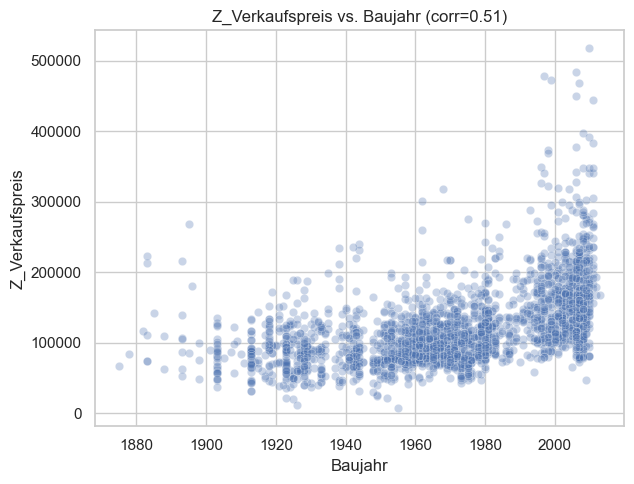

Kurze Interpretation: Wenn corr>0, steigt Z_Verkaufspreis tendenziell mit Baujahr; bei corr<0 tendenziell umgekehrt.


In [27]:
if target is not None and len(num_cols) >= 2:
    corr_to_target = (
        df[num_cols]
        .corr(numeric_only=True)[target]
        .drop(labels=[target], errors="ignore")
        .dropna()
        .sort_values(key=lambda s: s.abs(), ascending=False)
    )

    top_n_num = 3
    top_num_features = corr_to_target.head(top_n_num).index.tolist()

    print("Top numerische Features (nach |corr| mit Target):", top_num_features)

    for c in top_num_features:
        plt.figure(figsize=(6.5, 5))
        sns.scatterplot(data=df, x=c, y=target, alpha=0.3)
        plt.title(f"{target} vs. {c} (corr={corr_to_target.loc[c]:.2f})")
        plt.tight_layout()
        plt.show()

        print(f"Kurze Interpretation: Wenn corr>0, steigt {target} tendenziell mit {c}; bei corr<0 tendenziell umgekehrt.")
else:
    print("Top-n numerische Feature-Plots werden übersprungen (target fehlt oder zu wenige numerische Spalten).")


**Zwischenfazit:** Die stärksten linearen Zusammenhänge mit dem Verkaufspreis zeigen Wohnfläche, Gesamtqualität und Lage. Grundstücksgröße und Baujahr weisen schwächere bzw. nichtlineare Effekte auf und sollten ggf. mit flexibleren Modellen betrachtet werden.

In [28]:
"""### 2.6.6.1 Korrelationen einordnen (Top-3 + Hinweis auf Multikollinearität)

Wir interpretieren die Korrelationsanalyse explizit:
- **Top-3** Treiber nach absoluter Korrelation zum Ziel
- Beispielhafter Check auf **Multikollinearität** unter den Top-Features (stark korrelierte Prädiktoren)

**Kurzfazit:**
- Features mit hoher |corr| zum Target sind starke Kandidaten für die Modellierung.
- Wenn zwei starke Treiber **untereinander** hoch korrelieren, sollte man für lineare Modelle Regularisierung nutzen oder eines der Features entfernen.
"""


'### 2.6.6.1 Korrelationen einordnen (Top-3 + Hinweis auf Multikollinearität)\n\nWir interpretieren die Korrelationsanalyse explizit:\n- **Top-3** Treiber nach absoluter Korrelation zum Ziel\n- Beispielhafter Check auf **Multikollinearität** unter den Top-Features (stark korrelierte Prädiktoren)\n\n**Kurzfazit:**\n- Features mit hoher |corr| zum Target sind starke Kandidaten für die Modellierung.\n- Wenn zwei starke Treiber **untereinander** hoch korrelieren, sollte man für lineare Modelle Regularisierung nutzen oder eines der Features entfernen.\n'

In [29]:
if target is not None and len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)

    if target in corr.columns:
        corr_target = (
            corr[target]
            .drop(labels=[target], errors="ignore")
            .dropna()
            .sort_values(key=lambda s: s.abs(), ascending=False)
        )

        top3 = corr_target.head(3)
        display(top3.to_frame("corr_with_target"))

        if len(top3) >= 2:
            # Multikollinearität: paarweise Korrelation zwischen Top-Features ansehen
            top_feats = top3.index.tolist()
            pair_corr = corr.loc[top_feats, top_feats]
            display(pair_corr)
else:
    print("Korrelations-Interpretation wird übersprungen.")


,corr_with_target
Wohnflaeche_qm,0.656922
EG_qm,0.575700
Baujahr,0.505448


,Wohnflaeche_qm,EG_qm,Baujahr
Wohnflaeche_qm,1.000000,0.537217,0.210348
EG_qm,0.537217,1.000000,0.278744
Baujahr,0.210348,0.278744,1.000000


**Hinweis zur Interpretation der Korrelationen:** Das am stärksten korrelierte Feature zeigt den stärksten *linearen* Zusammenhang zum Target. Wenn die Top-Features untereinander stark korrelieren, kann das auf Multikollinearität hinweisen; für lineare Modelle sind dann Regularisierung oder Feature-Selektion sinnvoll.

In [30]:
"""### 2.6.7.1 Systematische Feature→Target-Beziehungen (kategorial)

Wir wählen die **informativsten** kategorialen Features (heuristisch: moderate Kardinalität) und zeigen
jeweils die Preisverteilung per Boxplot.

**Interpretation:** Kategorien mit klar getrennten Medianen sind starke Segmenttreiber.
"""


'### 2.6.7.1 Systematische Feature→Target-Beziehungen (kategorial)\n\nWir wählen die **informativsten** kategorialen Features (heuristisch: moderate Kardinalität) und zeigen\njeweils die Preisverteilung per Boxplot.\n\n**Interpretation:** Kategorien mit klar getrennten Medianen sind starke Segmenttreiber.\n'

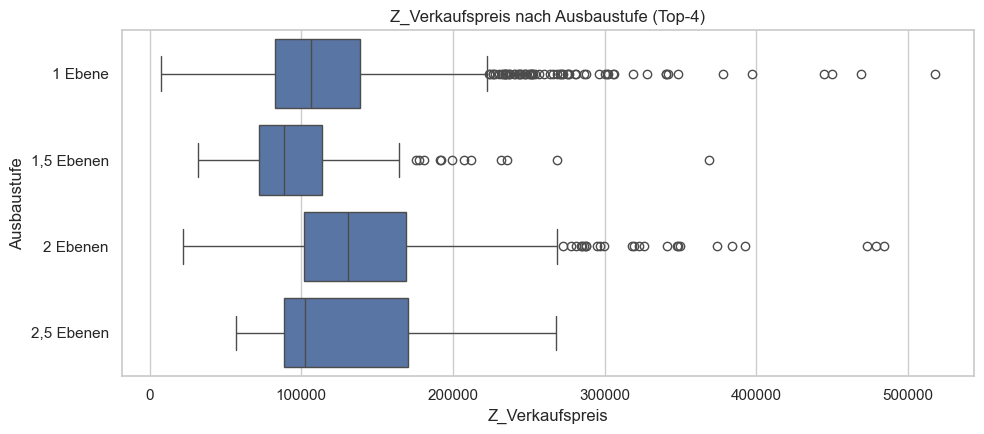

Kurze Interpretation: Wenn sich Median/Quartile zwischen Ausprägungen von 'Ausbaustufe' deutlich unterscheiden, ist das Feature ein starker Kandidat für die Modellierung (Encoding nötig).


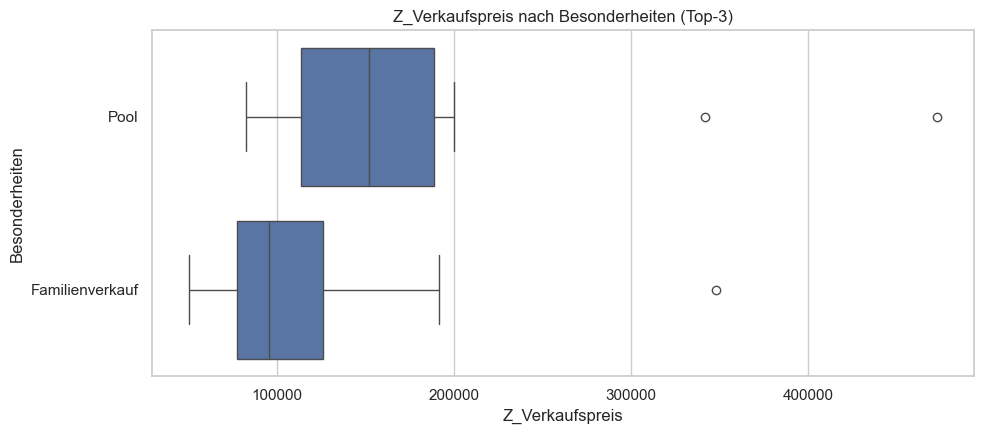

Kurze Interpretation: Wenn sich Median/Quartile zwischen Ausprägungen von 'Besonderheiten' deutlich unterscheiden, ist das Feature ein starker Kandidat für die Modellierung (Encoding nötig).


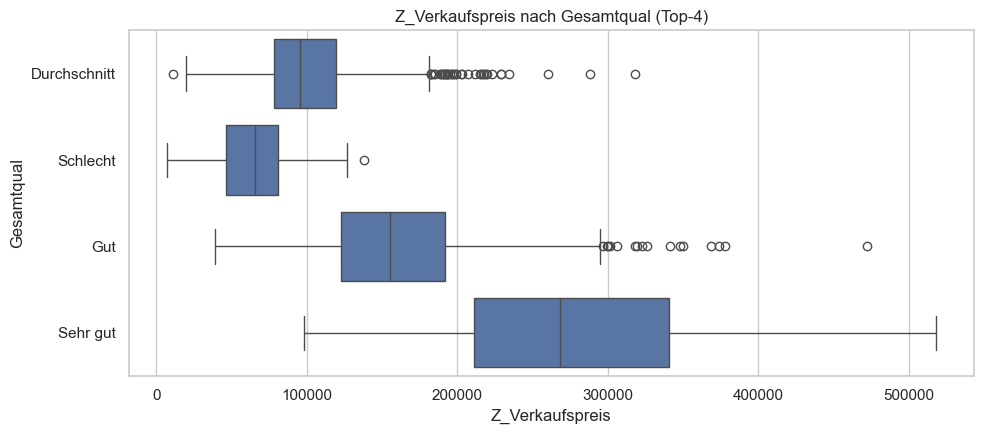

Kurze Interpretation: Wenn sich Median/Quartile zwischen Ausprägungen von 'Gesamtqual' deutlich unterscheiden, ist das Feature ein starker Kandidat für die Modellierung (Encoding nötig).


In [31]:
if target is not None:
    # Heuristik: Kategorien mit 2..20 Ausprägungen (zu viele = unübersichtlich, zu wenige = wenig Info)
    candidate_cat = []
    for c in cat_cols:
        nunique_val = df[c].nunique(dropna=True)
        try:
            nunique = int(nunique_val)
        except Exception:
            continue
        if 2 <= nunique <= 20:
            candidate_cat.append(c)

    # maximal 3 Boxplots ("weniger, aber sauber interpretiert")
    for c in candidate_cat[:3]:
        vc = df[c].astype("string").value_counts(dropna=False)
        top_levels = vc.index[:min(TOP_K, len(vc))].tolist()
        df_plot = df.loc[df[c].astype("string").isin(top_levels), [c, target]].copy()
        df_plot[c] = df_plot[c].astype("string")

        if df_plot.shape[0] >= 30:
            plt.figure(figsize=(10, 4.5))
            sns.boxplot(data=df_plot, y=c, x=target)
            plt.title(f"{target} nach {c} (Top-{min(TOP_K, len(top_levels))})")
            plt.tight_layout()
            plt.show()

            print(
                f"Kurze Interpretation: Wenn sich Median/Quartile zwischen Ausprägungen von '{c}' deutlich unterscheiden, "
                "ist das Feature ein starker Kandidat für die Modellierung (Encoding nötig)."
            )
else:
    print("Kategoriale Target-Beziehungen werden übersprungen (target fehlt).")


In [32]:
"""### 2.5.1 Plausibilitäts-Logikchecks

Neben reinen Negativ/Null-Checks sind einfache **Logikprüfungen** wichtig.
Typisch im Immobilienkontext:
- Umbaujahr/Modernisierungsjahr sollte nicht vor Baujahr liegen.

Diese Checks laufen nur, wenn entsprechende Spalten erkannt werden.
"""


'### 2.5.1 Plausibilitäts-Logikchecks\n\nNeben reinen Negativ/Null-Checks sind einfache **Logikprüfungen** wichtig.\nTypisch im Immobilienkontext:\n- Umbaujahr/Modernisierungsjahr sollte nicht vor Baujahr liegen.\n\nDiese Checks laufen nur, wenn entsprechende Spalten erkannt werden.\n'

In [33]:
# Heuristisch Spalten finden
build_year_col = _find_numeric_col_by_keywords(df, ["baujahr", "buildyear", "year_built", "built"])
renov_year_col = _find_numeric_col_by_keywords(df, ["umbau", "modern", "sanier", "renov", "year_renov", "remodel"])

if build_year_col is not None:
    by = df[build_year_col].dropna()
    if len(by) > 0:
        print(f"Baujahr '{build_year_col}': min={int(by.min())}, max={int(by.max())}")

if build_year_col is not None and renov_year_col is not None:
    mask = df[build_year_col].notna() & df[renov_year_col].notna()
    inconsistent = int(np.count_nonzero((df.loc[mask, renov_year_col].to_numpy() < df.loc[mask, build_year_col].to_numpy())))
    print(
        f"Logikcheck: Umbaujahr '{renov_year_col}' < Baujahr '{build_year_col}' → "
        f"{inconsistent} Fälle (sollte i.d.R. 0 sein)."
    )
else:
    print("Kein Baujahr/Umbaujahr-Paar gefunden – Logikcheck wird übersprungen.")


Baujahr 'Baujahr': min=1875, max=2013
Kein Baujahr/Umbaujahr-Paar gefunden – Logikcheck wird übersprungen.


🟢 Neue finale Fassung (Copy-Paste-fähig)
### 2.7 Zusammenfassung der wichtigsten Erkenntnisse aus der Data Exploration

- **Zielvariable `Z_Verkaufspreis`:**
  Der Verkaufspreis ist typischerweise rechtsschief verteilt und ausreißeranfällig.
  Für die Modellierung ist `log1p(Z_Verkaufspreis)` ein sinnvoller Kandidat.

- **Wichtigste Preistreiber:**
  Wohnfläche, Lage und Gesamtqualität zeigen die stärksten Zusammenhänge
  mit dem Verkaufspreis und sind zentrale Features für die Vorhersage.

- **Numerische Features & Korrelationen:**
  Die Top-3 numerischen Features nach |Korrelation| liefern eine sinnvolle erste
  Priorisierung potenzieller Preistreiber.
  Starke Feature-Feature-Korrelationen können lineare Modelle instabil machen.

- **Kategoriale Features:**
  Boxplots zeigen deutliche Preisunterschiede zwischen Kategorien
  (z. B. Lage, Zustand, Qualität), was deren hohe Relevanz bestätigt.

- **Konsequenzen für die Modellierung:**
  Ausreißer erscheinen fachlich plausibel und werden nicht entfernt.
  Es sind sowohl lineare als auch nichtlineare Zusammenhänge erkennbar,
  weshalb mehrere Modelltypen sinnvoll erscheinen.

### Übergang zu Aufgabe 3 (Data Preparation)

Aus der Exploration folgen konkret:
- Umgang mit **Ausreißern** und ggf. **Target-Transformation** (`log1p`).
- **Missing Values** je Feature gezielt behandeln (Imputation vs. Drop).
- **Encoding** kategorialer Features (One-Hot/Ordinal) und Bündelung seltener Kategorien.
- Optionales **Feature Engineering** (z.B. Gebäudealter), falls passende Spalten vorhanden sind.

---

# 3. Data Preparation
Ziel der Data Preparation ist es, auf Basis der Erkenntnisse aus der Data Exploration einen modellierbaren Datensatz zu erzeugen. Dabei werden fehlende Werte behandelt, Features transformiert und kategoriale Merkmale geeignet kodiert.


In [34]:
# 3.2 Zielvariable transformieren
df["Z_Verkaufspreis_log"] = np.log1p(df["Z_Verkaufspreis"])

Da der Verkaufspreis rechtsschief verteilt ist und extreme Werte enthält, wird für die
Modellierung eine logarithmisch transformierte Darstellung der Zielvariable verwendet.
Die Transformation reduziert die Schiefe der Verteilung und stabilisiert die Schätzung
der Regressionsmodelle, ohne die inhaltliche Bedeutung der Zielgröße zu verändern.

In [35]:
# 3.3 ID entfernen
df = df.drop(columns=["A_Index"])

Die Spalte `A_Index` dient ausschließlich der Identifikation der Datensätze und enthält keine inhaltliche Information. Um Zufallskorrelationen und Overfitting zu vermeiden, wird dieses Merkmal vor der Modellierung entfernt.


In [36]:
# 3.4 Feature Engineering: Gebäudealter
df["Gebaeudealter"] = df["Verkaufsjahr"] - df["Baujahr"]
df.loc[df["Gebaeudealter"] < 0, "Gebaeudealter"] = np.nan


Das Gebäudealter ist für Investoren besser interpretierbar als das Baujahr und wird daher als zusätzliches Feature verwendet.
Negative Gebäudealter werden als unplausibel betrachtet und als fehlend behandelt.


In [37]:
# 3.5 Kategoriale Merkmale: Ordinal-Encoding
ordinal_maps = {
    "Gesamtqual": {
        "Sehr schlecht": 1,
        "Schlecht": 2,
        "Durchschnitt": 3,
        "Gut": 4,
        "Sehr gut": 5
    },
    "Gesamtzustand": {
        "Sehr schlecht": 1,
        "Schlecht": 2,
        "Durchschnitt": 3,
        "Gut": 4,
        "Sehr gut": 5
    },
    "Kellerhoehe": {
        "Keine Angabe": 0,
        "Sehr schlecht": 1,
        "Schlecht": 2,
        "Durchschnitt": 3,
        "Gut": 4,
        "Sehr gut": 5
    }
}

for col, mapping in ordinal_maps.items():
    # Missing/Unknown sauber auseinanderhalten: wir zählen nur NaNs, die durch das Mapping neu entstehen.
    s_raw = df[col]
    na_before = int(s_raw.isna().sum())

    df[col] = s_raw.map(mapping)

    na_after = int(df[col].isna().sum())
    introduced_by_map = na_after - na_before

    if introduced_by_map > 0:
        # Beispiele für unbekannte Kategorien (max. 10), damit man das Mapping gezielt erweitern kann.
        unknown_examples = sorted(set(s_raw.dropna().astype(str)) - set(mapping.keys()))[:10]
        print(
            f"Warnung: {introduced_by_map} unbekannte Ausprägungen in '{col}' "
            f"(durch Mapping zu NaN). Beispiele: {unknown_examples}"
        )

Warnung: 1 unbekannte Ausprägungen in 'Gesamtzustand' (durch Mapping zu NaN). Beispiele: ['Sehr Schlecht']
Warnung: 2 unbekannte Ausprägungen in 'Kellerhoehe' (durch Mapping zu NaN). Beispiele: ['Sehr Schlecht']


Ordinal skalierte Merkmale werden entsprechend ihrer natürlichen Rangfolge kodiert, um die enthaltene Ordnung für lineare Modelle nutzbar zu machen.
Nach dem ordinalen Encoding wurde geprüft, ob unbekannte Kategorien aufgetreten sind. Eventuell entstehende fehlende Werte werden im nächsten Schritt imputiert.



In [38]:
# 3.6 Kategoriale Merkmale: One-Hot-Encoding
df = pd.get_dummies(
    df,
    columns=["Lage", "Ausbaustufe", "Steigung", "Besonderheiten"],
    drop_first=True
)

Nominale Merkmale ohne natürliche Ordnung werden mittels One-Hot-Encoding transformiert.
Für die spätere Modellierung ist sicherzustellen, dass Trainings- und Testdaten dieselben Dummy-Spalten besitzen. Dies kann z. B. über ein Alignment der Spalten oder den Einsatz von Pipelines erreicht werden.


In [39]:
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include=["number"]).columns.difference(
["Z_Verkaufspreis", "Z_Verkaufspreis_log"]
)


imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])


Fehlende Werte in numerischen Merkmalen werden mittels Median-Imputation ersetzt.
Die Zielvariablen Z_Verkaufspreis und Z_Verkaufspreis_log werden nicht imputiert und
explizit vom Feature Set ausgeschlossen.

## Fazit der Data Preparation
Die Data Preparation umfasst die Transformation der Zielvariable in logarithmierter Form,
die Entfernung irrelevanter Merkmale, die Erstellung neuer Features sowie die Kodierung
und Imputation erklärender Merkmale. Die log-transformierte Zielvariable wird ausschließlich
als Regressionsziel verwendet und nicht als Feature in die Modelle eingebracht.

# 4 Modeling – Regression mit Inferenz  

**4.1 Ziel und Vorgehen**  
Ziel dieses Abschnitts ist die Vorhersage des Verkaufspreises einer Immobilie auf Basis ihrer objektbezogenen Merkmale.
Hierzu werden mehrere Regressionsmodelle trainiert und anhand geeigneter Gütemaße miteinander verglichen.
Das Modell mit der besten Vorhersageleistung wird anschließend für Prognosen auf den Testdaten verwendet.
Der Fokus liegt dabei nicht nur auf der reinen Vorhersagequalität, sondern auch auf der Interpretierbarkeit der preisbestimmenden Merkmale.

**4.2 Zielvariable und Feature-Auswahl**

Die Zielvariable der Regression ist der Verkaufspreis der Immobilie
(Z_Verkaufspreis).

Als erklärende Variablen werden alle numerischen Objektmerkmale herangezogen,
wobei die Zielvariable selbst sowie daraus abgeleitete Transformationen
nicht Bestandteil des Feature-Sets sind.
Auf diese Weise wird sichergestellt, dass die Vorhersage ausschließlich auf
objektbeschreibenden Merkmalen basiert und keine direkte Zielinformation
in die Modellschätzung einfließt.

**4.3 Datenaufteilung in Trainings- und Validierungsdaten**  
Um die Generalisierungsfähigkeit der Modelle zu bewerten, werden die Daten in Trainings- und Validierungsdaten aufgeteilt.
Die Validierungsdaten werden ausschließlich zur Bewertung der Modelle verwendet.

In [40]:
from sklearn.model_selection import train_test_split

# Zielvariable
y = df["Z_Verkaufspreis"]

# Features: alle numerischen Spalten außer Zielvariable
X = df.select_dtypes(include="number").drop(
 columns=["Z_Verkaufspreis", "Z_Verkaufspreis_log"]
)

# Aufteilung in Trainings- und Validierungsdaten
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)

Trainingsdaten: (1907, 11)
Validierungsdaten: (477, 11)


**4.4 Baseline Modell: Lineare Regression**  
Als Basismodell wird eine lineare Regression verwendet.
Dieses Modell dient als Referenz, da es einfach interpretierbar ist und häufig als Ausgangspunkt für Regressionsaufgaben eingesetzt wird.

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_val)

rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

print("Lineare Regression")
print("RMSE:", round(rmse_lr, 2))
print("R²:", round(r2_lr, 3))

Lineare Regression
RMSE: 25291.11
R²: 0.786


**4.5 Regularisiertes Modell: Ridge Regression**  
Die Ridge Regression erweitert die lineare Regression um eine Regularisierung.
Dadurch können instabile Koeffizienten reduziert und Überanpassung vermieden werden, insbesondere bei korrelierten Merkmalen.

In [42]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_val)

rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))
r2_ridge = r2_score(y_val, y_pred_ridge)

print("Ridge Regression")
print("RMSE:", round(rmse_ridge, 2))
print("R²:", round(r2_ridge, 3))

Ridge Regression
RMSE: 25294.0
R²: 0.786


**4.6 Nichtlineares Modell: Random Forest Regression**  
Zur Modellierung nichtlinearer Zusammenhänge wird ein Random Forest Regressor eingesetzt.
Dieses Modell kombiniert viele Entscheidungsbäume und ist in der Lage, komplexe Abhängigkeiten zwischen Merkmalen abzubilden.

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest Regression")
print("RMSE:", round(rmse_rf, 2))
print("R²:", round(r2_rf, 3))

Random Forest Regression
RMSE: 21146.97
R²: 0.85


**4.7 Modellvergleich und Auswahl**  
Die Modelle werden anhand des Root Mean Squared Error (RMSE) sowie des Bestimmtheitsmaßes R² verglichen.
Das Modell mit dem niedrigsten RMSE und der höchsten erklärten Varianz wird als bestes Modell ausgewählt.
In dieser Analyse zeigt der Random Forest Regressor die beste Vorhersageleistung und wird daher für weitere Prognosen verwendet.

**4.8 Finales Modell für Prognose**

In [44]:
# Finales Random-Forest-Modell auf allen Trainingsdaten
final_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

**4.9 Interpretation der Einflussfaktoren**  
Zur Interpretation der Ergebnisse werden die Koeffizienten der linearen Regression sowie die Feature Importances des Random Forest betrachtet.
Dies ermöglicht eine Einschätzung, welche Merkmale den Verkaufspreis besonders stark beeinflussen.

**Lineare Regression: Einfluss der Merkmale auf den Verkaufspreis**

In [45]:
coef_df = (
    pd.DataFrame({
        "Merkmal": X.columns,
        "Koeffizient": lin_reg.coef_
    })
    .sort_values(by="Koeffizient", key=abs, ascending=False)
)

coef_df.head(10)


,Merkmal,Koeffizient
2,Gesamtqual,22928.244637
5,Kellerhoehe,12615.720672
8,Verkaufsjahr,7003.772268
3,Gesamtzustand,5267.490335
9,Wohnflaeche_qm,445.279815
10,Gebaeudealter,-329.117025
1,EG_qm,313.021539
7,Umgebaut,154.198129
0,Baujahr,-94.173197
6,QualInnenfarbe,-27.549721


**Random Forest: Relative Bedeutung der Merkmale für die Preisvorhersage**

In [46]:
importances = (
    pd.Series(rf.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
)

importances.head(10)

Gesamtqual        0.291516
Wohnflaeche_qm    0.238761
EG_qm             0.124346
Verkaufsjahr      0.121504
Baujahr           0.084505
Grundstueck_qm    0.049438
Kellerhoehe       0.029329
Umgebaut          0.024986
Gebaeudealter     0.021610
QualInnenfarbe    0.009332
dtype: float64

**4.10 Einordnung von Varianz und Verzerrung**

Die lineare Regression weist eine vergleichsweise hohe Verzerrung auf, da sie ausschließlich lineare Zusammenhänge zwischen den Merkmalen und dem Verkaufspreis abbilden kann. Nichtlineare Effekte, insbesondere Interaktionen zwischen Lage, Qualität und Wohnfläche, können nur eingeschränkt erfasst werden. Dies zeigt sich in einer geringeren erklärten Varianz im Vergleich zu komplexeren Modellen.

Die Ridge-Regression reduziert zwar die Varianz der Schätzung durch Regularisierung der Koeffizienten, führt jedoch nicht zu einer signifikanten Verbesserung der Vorhersagegüte gegenüber der klassischen linearen Regression. Die zugrundeliegende Modellannahme bleibt weiterhin linear, sodass strukturelle Nichtlinearitäten unberücksichtigt bleiben.

Der Random Forest-Regressor weist im Vergleich dazu eine geringere Verzerrung auf, da er nichtlineare Zusammenhänge sowie Wechselwirkungen zwischen Merkmalen explizit modellieren kann. Durch die Aggregation vieler Entscheidungsbäume wird gleichzeitig die Varianz einzelner Modelle reduziert. Insgesamt ergibt sich damit ein günstigeres Bias-Variance-Verhältnis.

**4.11 Vergleich der Regressionsmodelle**

Der Vergleich der Modelle anhand von RMSE und R² zeigt, dass beide linearen Modelle eine ähnliche Vorhersageleistung erzielen. Die Ridge-Regression bietet gegenüber der einfachen linearen Regression keinen deutlichen Vorteil, was darauf hindeutet, dass Multikollinearität zwar vorhanden, aber nicht dominierend ist.

Der Random Forest-Regressor erreicht hingegen den niedrigsten RMSE sowie das höchste Bestimmtheitsmaß. Dies spricht für eine bessere Anpassung an die Datenstruktur und eine höhere Prognosegüte. Insbesondere die Fähigkeit, nichtlineare Effekte abzubilden, erweist sich bei der Immobilienpreisvorhersage als entscheidend.

**4.12 Interpretation der Einflussfaktoren im Modellvergleich**

Die Koeffizienten der linearen Regression zeigen, dass insbesondere Gesamtqualität, Kellerhöhe, Verkaufsjahr und Wohnfläche einen positiven Einfluss auf den Verkaufspreis haben. Diese Effekte sind inhaltlich plausibel und gut interpretierbar, allerdings nur unter der Annahme linearer Zusammenhänge.

Die Feature Importances des Random Forest bestätigen diese Ergebnisse, priorisieren jedoch zusätzlich Wohnfläche und Gesamtqualität als wichtigste Einflussfaktoren. Im Gegensatz zur linearen Regression berücksichtigt das Modell dabei auch nichtlineare Schwellen- und Interaktionseffekte, was die höhere Vorhersageleistung erklärt.

**4.13 Modellfazit**

Auf Basis der quantitativen Gütemaße sowie der qualitativen Interpretation der Ergebnisse wird der Random Forest-Regressor als bestes Modell ausgewählt. Er bietet die höchste Prognosegenauigkeit bei gleichzeitig robuster Modellierung komplexer Zusammenhänge. Dieses Modell wird daher für die Vorhersage der Verkaufspreise auf den Testdaten verwendet.

**4.14 Modellanwendung und Vorhersage auf Testdaten**

Auf Basis des Modellvergleichs wird der Random Forest-Regressor als finales Modell ausgewählt. 
Um die bestmögliche Prognosequalität zu erzielen, wird dieses Modell abschließend auf allen 
verfügbaren Trainingsdaten neu trainiert.

Das so refittete Modell wird anschließend verwendet, um Verkaufspreisprognosen für die 
extern bereitgestellten Testdaten zu erzeugen. Die vorhergesagten Werte werden in eine neue 
Spalte der Datei *data_for_test.csv* geschrieben. Das ursprüngliche Datenformat sowie die 
Reihenfolge der Beobachtungen bleiben dabei unverändert.miritest3

In [47]:
# Laden der externen Testdaten
df_test = pd.read_csv("data_for_test.csv", sep=";")

# Vorverarbeitung der Testdaten (identisch zu Trainingsdaten)

# ID entfernen
df_test = df_test.drop(columns=["A_Index"])

# Feature Engineering
df_test["Gebaeudealter"] = df_test["Verkaufsjahr"] - df_test["Baujahr"]
df_test.loc[df_test["Gebaeudealter"] < 0, "Gebaeudealter"] = np.nan

# Ordinal Encoding
df_test["Gesamtqual"] = df_test["Gesamtqual"].map(ordinal_maps["Gesamtqual"])
df_test["Gesamtzustand"] = df_test["Gesamtzustand"].map(ordinal_maps["Gesamtzustand"])
df_test["Kellerhoehe"] = df_test["Kellerhoehe"].map(ordinal_maps["Kellerhoehe"])

# One-Hot-Encoding
df_test = pd.get_dummies(
    df_test,
    columns=["Lage", "Ausbaustufe", "Steigung", "Besonderheiten"],
    drop_first=True
)

df_test = df_test.reindex(columns=X.columns, fill_value=0)

df_test[X.columns] = imputer.transform(
df_test[X.columns].to_numpy()
)

X_test = df_test[X.columns]

# Vorhersage
df_test["Z_Verkaufspreis_Prediction"] = final_model.predict(X_test)

# Speicherung der Datei
df_test.to_csv(
"data_for_test_filled.csv",
sep=";",
decimal=",",
index=False
)

c:\Users\mirim\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
